In [1]:
# Using this location as a root Directory
import os
ROOT = "/content/drive/MyDrive/Colab Notebooks/Deep learning"
os.chdir(ROOT)

In [2]:
# Checking all the avaliable files
# os.listdir()

In [3]:
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle/

In [4]:
!kaggle datasets download -d arjuntejaswi/plant-village

plant-village.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('plant-village.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

#### Deleting the files which are not required run this only if you are using google colab

In [6]:
rm -rf "/content/PlantVillage/Pepper__bell___Bacterial_spot"

In [7]:
rm -rf "/content/PlantVillage/Pepper__bell___healthy"

In [8]:
rm -rf "/content/PlantVillage/Tomato_Bacterial_spot"

In [9]:
rm -rf "/content/PlantVillage/Tomato_Early_blight"

In [10]:
rm -rf "/content/PlantVillage/Tomato_Late_blight"

In [11]:
rm -rf "/content/PlantVillage/Tomato_Late_Mold"

In [12]:
rm -rf "/content/PlantVillage/Tomato_Septoria_leaf_spot"

In [13]:
rm -rf "/content/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite"

In [14]:
rm -rf "/content/PlantVillage/Tomato__Target_Spot"

In [15]:
rm -rf "/content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus"

In [16]:
rm -rf "/content/PlantVillage/Tomato__Tomato_mosaic_virus"

In [17]:
rm -rf "/content/PlantVillage/Tomato_healthy"

In [18]:
rm -rf "/content/PlantVillage/Tomato_Leaf_Mold"

In [19]:
# Importig the libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [20]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [21]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)   

Found 2152 files belonging to 3 classes.


In [22]:
class_names = dataset.class_names

In [23]:
len(dataset)

68

###  Why 68 images

batch * 32 = 68 * 32 = 2176

**Last batch is not proper thats why it is showing more**

In [24]:
68*32

2176

In [25]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0]


In [26]:
# first image array 
for image_batch, label_batch in dataset.take(1):
    # print(image_batch[0].numpy())
    print(image_batch[0].shape)


(256, 256, 3)


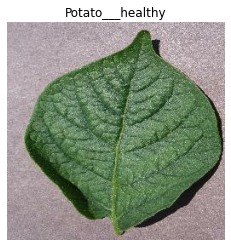

In [27]:
# Plotting the image 
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

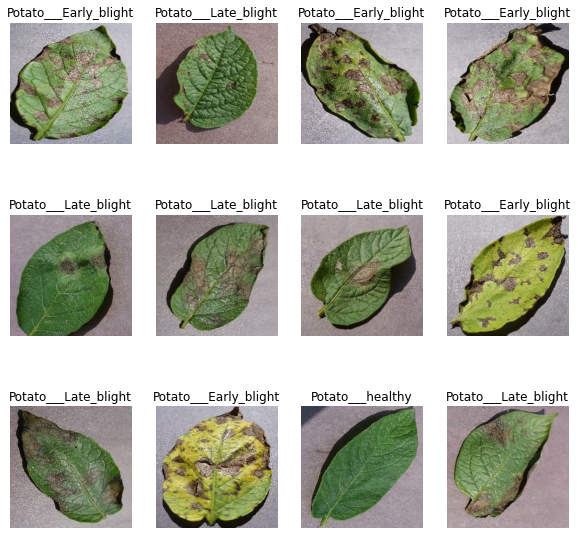

In [28]:
# Plotting the image 
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [29]:
len(dataset)

68

80% --> Training

20% --> 10% validation, 10% testing

# Function to Split Dataset

**Dataset should be bifurcated into 3 subsets, namely:**

* Training: Dataset to be used while training
* Validation: Dataset to be tested against while training
* Test: Dataset to be tested against after we trained a model

In [30]:
from tensorflow.python import train
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [31]:
train_ds = dataset.take(54)
len(train_ds)

54

In [32]:
# Skiping the first 54 dataset
test_ds = dataset.skip(54)
len(test_ds)

14

In [33]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [34]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [35]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [36]:
def spliting_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, 
                        shuffle=True, shuffle_size=10000):
    try:
        ds_size = len(ds)

        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=100)

        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)

        return train_ds, val_ds, test_ds
    except Exception as e:
        print(e)

In [37]:
train_ds, val_ds, test_ds = spliting_dataset_tf(dataset)

In [38]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [39]:
# Prefetching and cacheing
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#Building the Model
* Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

* You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [40]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [43]:
# data Augumentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Model Architecture
* We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

* We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [44]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [45]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 18s 115ms/step - loss: 0.9224 - accuracy: 0.4913 - val_loss: 0.8089 - val_accuracy: 0.4688
Epoch 2/50
54/54 [==============================] - 4s 71ms/step - loss: 0.7722 - accuracy: 0.6030 - val_loss: 0.6438 - val_accuracy: 0.7240
Epoch 3/50
54/54 [==============================] - 4s 70ms/step - loss: 0.4868 - accuracy: 0.7882 - val_loss: 0.4576 - val_accuracy: 0.7865
Epoch 4/50
54/54 [==============================] - 4s 71ms/step - loss: 0.4628 - accuracy: 0.7922 - val_loss: 0.2868 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 4s 71ms/step - loss: 0.3517 - accuracy: 0.8594 - val_loss: 0.2158 - val_accuracy: 0.9115
Epoch 6/50
54/54 [==============================] - 4s 71ms/step - loss: 0.2631 - accuracy: 0.8976 - val_loss: 0.2714 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 4s 71ms/step - loss: 0.2165 - accuracy: 0.9138 - val_loss: 0.1591 - val_accuracy: 0.9375
Epoch 8/50


In [48]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 32ms/step - loss: 0.0236 - accuracy: 0.9961


In [49]:
scores

[0.02360023744404316, 0.99609375]

Plotting the Accuracy and Loss Curves

In [51]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
type(history.history['loss'])

list

In [54]:
len(history.history['loss'])

50

In [55]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9223984479904175,
 0.7721615433692932,
 0.48681360483169556,
 0.46281930804252625,
 0.3516550660133362]

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

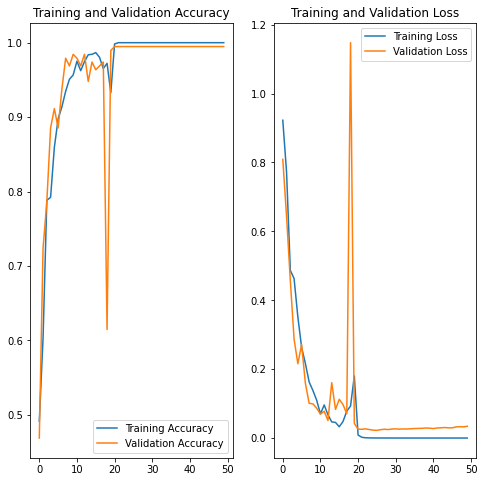

In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 223ms/step
predicted label: Potato___Early_blight


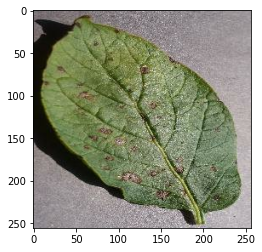

In [58]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write a function for inference

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Now run inference on few sample images

1/1 [==============================] - 0s 18ms/step


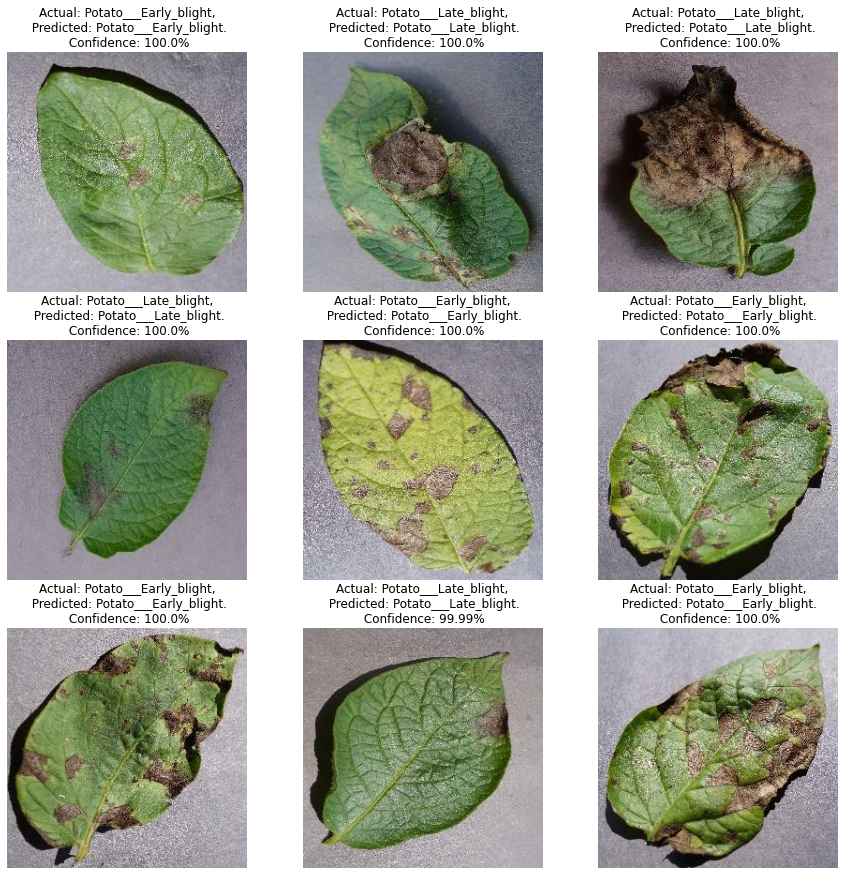

In [61]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [68]:
# ls

In [81]:
import os
model_version = max([int(i) for i in os.listdir("potato_models") + [0]])+1
print(model_version)
model.save(f"/potato_models/{model_version}")

2


In [70]:
# model.save("potato_models/potatoes.h5")